# Pulse sequence evaluation

Using arbitrary units. Energy is normalized to the standard deviation in chemical shift strengths. Reduced Planck's constant $\hbar \equiv 1$.

In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import pandas as pd
import multiprocessing as mp
import importlib

In [2]:
sys.path.append('..')

In [3]:
import pulse_sequences as ps
import pulse_sequence_data as psd

In [37]:
# importlib.reload(ps)
importlib.reload(psd)

<module 'pulse_sequence_data' from '../pulse_sequence_data.py'>

## Define system

In [4]:
dipolar_strength = 1e2
pulse_width = 1e-5  # time is relative to chemical shift strength
delay = 1e-4
rot_error = 1e-2
N = 3  # number of spins
ensemble_size = 25

In [5]:
X, Y, Z = ps.get_collective_spin(N)

In [6]:
Hsys_ensemble = [ps.get_Hsys(N, dipolar_strength=dipolar_strength) for _ in range(ensemble_size)]
pulses_ensemble = []
for H in Hsys_ensemble:
    rot = np.random.normal(scale=rot_error)
    pulses_ensemble.append(ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot))

In [7]:
Utarget = qt.identity(Hsys_ensemble[0].dims[0])

## Evaluate robustness

Looking at several different sources of errors:

- Non-negligible higher-order terms in Magnus expansion
- Rotation errors
- Phase transients
- Offset errors

### Rotation errors

In [9]:
rot_errors = np.geomspace(1e-4, 1e-1, 20)
rot_errors = np.concatenate([-rot_errors, [0], rot_errors])
rot_errors.sort()

In [10]:
def f(pulse_sequence, rot_error):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble]
    U_ensemble = [ps.get_propagator(pulse_sequence, p) for p in pe]
    U_ensemble_full = []
    for U in U_ensemble:
        U_full = qt.identity(U.dims[0])
        for _ in range(int(288/len(pulse_sequence))):
            U_full = U * U_full
        U_ensemble_full.append(U_full)
    fidelities = np.array([qt.metrics.average_gate_fidelity(U, Utarget)
                           for U in U_ensemble_full])
    return np.mean(fidelities), np.std(fidelities)

In [11]:
def get_rot_data(pulse_sequence, rot_errors, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.starmap(f, [(pulse_sequence, r) for r in rot_errors])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [12]:
cory48_output = get_rot_data(psd.cory48, rot_errors)

In [13]:
yxx48_output = get_rot_data(psd.yxx48, rot_errors)

In [66]:
# sequences from 3/6-3/8 jobs
# az12_output = get_rot_data(psd.az12_3, rot_errors)
# az24_output = get_rot_data(osd.az24_2, rot_errors)
# az36_output = get_rot_data(psd.az36, rot_errors)
# az96_output = get_rot_data(psd.az96, rot_errors)

In [38]:
# from 3/15-17 jobs
# unconstrained 12 pulse sequence
az12_unc_output = get_rot_data(psd.az12_unconstrained, rot_errors)
# unconstrained 24 pulse sequence
az24_unc_output = get_rot_data(psd.az24_unconstrained_2, rot_errors)
# from 3/16
az36_unc_output = get_rot_data(psd.az36_unconstrained, rot_errors)
az48_unc_output = get_rot_data(psd.az48_unconstrained_2, rot_errors)

In [47]:
# # best 48-pulse sequence so far
az48_output = get_rot_data(psd.az48_3, rot_errors)

In [50]:
# really robust to phase transients, otherwise terrible
az48_robust_output = get_rot_data(psd.az48_robust, rot_errors)

In [17]:
# default figure size is [6.0, 4.0]
plt.rcParams['figure.figsize'] = [5, 3.33]
# default dpi is 72
plt.rcParams['figure.dpi'] = 144

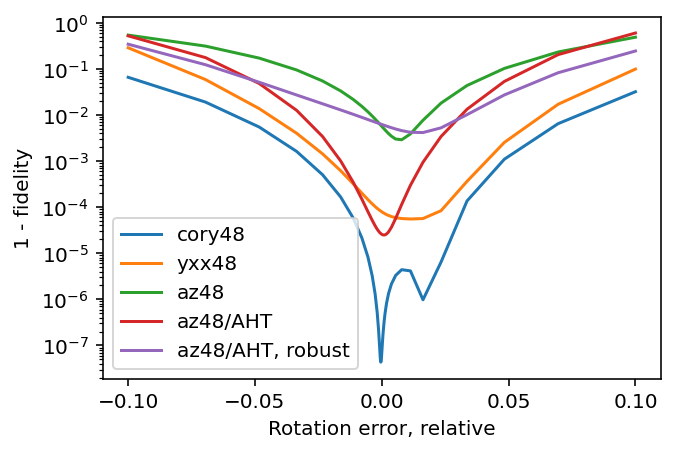

In [51]:
plt.plot(rot_errors, 1-cory48_output[0], label='cory48')
plt.plot(rot_errors, 1-yxx48_output[0], label='yxx48')

# plt.plot(rot_errors, 1-az48_robust_output[0], label='az48 robust')

# plt.plot(rot_errors, 1-az12_unc_output[0], label='az12')
# plt.plot(rot_errors, 1-az24_unc_output[0], label='az24')
# plt.plot(rot_errors, 1-az36_unc_output[0], label='az36')
plt.plot(rot_errors, 1-az48_unc_output[0], label='az48')

plt.plot(rot_errors, 1-az48_output[0], label='az48/AHT')

plt.plot(rot_errors, 1-az48_robust_output[0], label='az48/AHT, robust')

# plt.vlines(0, 10**-9, 10**-2, 'k')
plt.title(r'Infidelity over 288$\tau$')
plt.xlabel('Rotation error, relative')
plt.ylabel('1 - fidelity')
plt.xticks(ticks=np.linspace(-.1, .1, 5))
# plt.xscale('symlog', linthresh=1e-2)
# plt.vlines([-2e-3, 2e-3], [1e-8]*2, [1e-1]*2, 'black', 'dotted')
plt.yscale('log')
plt.legend()
plt.savefig('rot_errors.pdf', bbox_inches='tight')

### Phase transients

In [19]:
phase_transients = np.geomspace(1e-5, 1e-2, 20)
phase_transients = np.concatenate([[0], phase_transients])
phase_transients.sort()

In [20]:
def g(pulse_sequence, pt):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, phase_transient=pt) for H in Hsys_ensemble]
    U_ensemble = [ps.get_propagator(pulse_sequence, p) for p in pe]
    U_ensemble_full = []
    for U in U_ensemble:
        U_full = qt.identity(U.dims[0])
        for _ in range(int(288/len(pulse_sequence))):
            U_full = U * U_full
        U_ensemble_full.append(U_full)
    fidelities = np.array([qt.metrics.average_gate_fidelity(U, Utarget)
                           for U in U_ensemble_full])
    return np.mean(fidelities), np.std(fidelities)

In [21]:
def get_pt_data(pulse_sequence, phase_transients, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.starmap(g, [(pulse_sequence, r) for r in phase_transients])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [23]:
cory48_pt_output = get_pt_data(psd.cory48, phase_transients)

In [24]:
yxx48_pt_output = get_pt_data(psd.yxx48, phase_transients)

In [57]:
# az12_pt_output = get_pt_data(psd.az12_3, phase_transients)
# az24_pt_output = get_pt_data(psd.az24_2, phase_transients)
# az36_pt_output = get_pt_data(psd.az36, phase_transients)
# az96_pt_output = get_pt_data(psd.az96, phase_transients)

In [41]:
# from 3/15-??? jobs
# unconstrained 12 pulse sequence
az12_unc_pt_output = get_pt_data(psd.az12_unconstrained, phase_transients)
# unconstrained 24 pulse sequence
az24_unc_pt_output = get_pt_data(psd.az24_unconstrained_2, phase_transients)
az36_unc_pt_output = get_pt_data(psd.az36_unconstrained, phase_transients)
az48_unc_pt_output = get_pt_data(psd.az48_unconstrained_2, phase_transients)

In [45]:
az48_pt_output = get_pt_data(psd.az48_3, phase_transients)

In [52]:
az48_robust_pt_output = get_pt_data(psd.az48_robust, phase_transients)

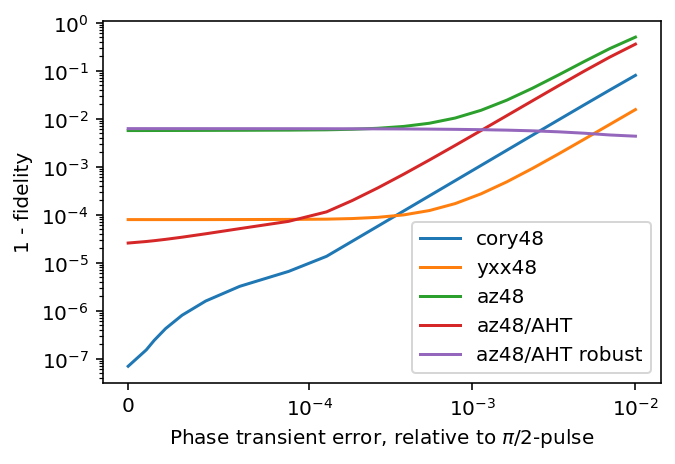

In [53]:
plt.plot(phase_transients, 1-cory48_pt_output[0], label='cory48')
plt.plot(phase_transients, 1-yxx48_pt_output[0], label='yxx48')

# plt.plot(phase_transients, 1-az12_pt_output[0], label='az12')
# plt.plot(phase_transients, 1-az24_pt_output[0], label='az24')
# plt.plot(phase_transients, 1-az36_pt_output[0], label='az36')
# plt.plot(phase_transients, 1-az48_3_pt_output[0], label='az48')
# plt.plot(phase_transients, 1-az96_pt_output[0], label='az96')

# plt.plot(phase_transients, 1-az12_unc_pt_output[0], label='az12')
# plt.plot(phase_transients, 1-az24_unc_pt_output[0], label='az24')
# plt.plot(phase_transients, 1-az36_unc_pt_output[0], label='az36')
plt.plot(phase_transients, 1-az48_unc_pt_output[0], label='az48')

plt.plot(phase_transients, 1-az48_pt_output[0], label='az48/AHT')

plt.plot(phase_transients, 1-az48_robust_pt_output[0], label='az48/AHT robust')

plt.title(r'Infidelity over 288$\tau$')
plt.xscale('symlog', linthresh=1e-4)
plt.yscale('log')
plt.xlabel(r'Phase transient error, relative to $\pi/2$-pulse')
plt.ylabel('1 - fidelity')
plt.legend()
plt.savefig('phase_transients.pdf', bbox_inches='tight')

## Evaluate AZ performance by pulse sequence length

In [10]:
U12 = [ps.get_propagator(az12, p) for p in pulses_ensemble]
U24 = [ps.get_propagator(az24, p) for p in pulses_ensemble]
U36 = [ps.get_propagator(az36, p) for p in pulses_ensemble]
U48 = [ps.get_propagator(az48, p) for p in pulses_ensemble]
U96 = [ps.get_propagator(az96, p) for p in pulses_ensemble]

In [24]:
len(ps.cory48)

72

In [25]:
np.lcm.reduce([12, 24, 36, 48, 72, 96])

288

In [12]:
U12_full = []
for U in U12:
    U_full = qt.identity(U.dims[0])
    for _ in range(int(288/12)):
        U_full = U * U_full
    U12_full.append(U_full)

In [13]:
U24_full = []
for U in U24:
    U_full = qt.identity(U.dims[0])
    for _ in range(int(288/24)):
        U_full = U * U_full
    U24_full.append(U_full)

In [14]:
U36_full = []
for U in U36:
    U_full = qt.identity(U.dims[0])
    for _ in range(int(288/36)):
        U_full = U * U_full
    U36_full.append(U_full)

In [15]:
U48_full = []
for U in U48:
    U_full = qt.identity(U.dims[0])
    for _ in range(int(288/48)):
        U_full = U * U_full
    U48_full.append(U_full)

In [16]:
U96_full = []
for U in U96:
    U_full = qt.identity(U.dims[0])
    for _ in range(int(288/96)):
        U_full = U * U_full
    U96_full.append(U_full)

In [17]:
fid12 = np.array([qt.metrics.average_gate_fidelity(U, qt.identity([2]*3)) for U in U12_full])
fid24 = np.array([qt.metrics.average_gate_fidelity(U, qt.identity([2]*3)) for U in U24_full])
fid36 = np.array([qt.metrics.average_gate_fidelity(U, qt.identity([2]*3)) for U in U36_full])
fid48 = np.array([qt.metrics.average_gate_fidelity(U, qt.identity([2]*3)) for U in U48_full])
fid96 = np.array([qt.metrics.average_gate_fidelity(U, qt.identity([2]*3)) for U in U96_full])

In [18]:
fid_means = np.array([fid12.mean(), fid24.mean(), fid36.mean(), fid48.mean(), fid96.mean()])

In [19]:
fid_stds = np.array([fid12.std(), fid24.std(), fid36.std(), fid48.std(), fid96.std()])

In [20]:
fid_stds

array([0.070728  , 0.00023681, 0.00869011, 0.00071491, 0.00106102])

Fidelities are corrected for differences in pulse sequence length.

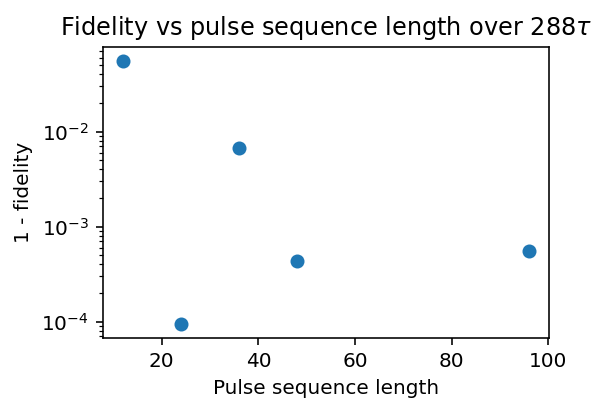

In [23]:
plt.scatter([12, 24, 36, 48, 96], 1 - fid_means)
plt.yscale('log')
plt.xlabel('Pulse sequence length')
plt.ylabel('1 - fidelity')
plt.title(r'Fidelity vs pulse sequence length over 288$\tau$')
plt.savefig('pulse-sequence-length.pdf', bbox_inches='tight')